<a href="https://colab.research.google.com/github/gitHubAndyLee2020/Monte_Carlo_Chess_Agent/blob/main/monte_carlo_chess_agent_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chess Agent using Monte Carlo Search Tree Algorithm

In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
import chess
import chess.pgn
import chess.engine
import random
import time
from math import log, sqrt, e, inf

In [ ]:
class node():
  def __init__(self):
    self.state = chess.Board()
    self.action = ''
    self.children = set()
    self.parent = None
    self.N = 0
    self.n = 0
    self.v = 0

In [ ]:
# Determines how valuate a node is to be explored
def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

In [ ]:
# Handles leaf node case, make random moves until the game is over
def rollout(curr_node):
  # Return reward value if the game is over
  if (curr_node.state.is_game_over()):
    board = curr_node.state
    if (board.result() == '1-0'):
      print("h1")
      return (1, curr_node)
    elif (board.result() == '0-1'):
      print("h2")
      return (-1, curr_node)
    else:
      return (0.5, curr_node)

  # If the game is not over, get list of all possible moves
  all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]

  # Get child node for each possible move
  for i in all_moves:
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(i)
    child = node()
    child.state = tmp_state
    child.parent = curr_node
    curr_node.children.add(child)

  # Get a random move
  rnd_state = random.choice(list(curr_node.children))

  return rollout(rnd_state)

In [ ]:
# Select the most promising child node
def expand(curr_node, white):
  if (len(curr_node.children) == 0):
    return curr_node
  max_ucb = -inf
  if (white):
    idx = -1
    max_ucb = -inf
    sel_child = None
    for i in curr_node.children:
      tmp = ucb1(i)
      if (tmp > max_ucb):
        idx = i
        max_ucb = tmp
        sel_child = i

    return expand(sel_child, 0)

  else:
    idx = -1
    min_ucb = inf
    sel_child = None
    for i in curr_node.children:
      tmp = ucb1(i)
      if (tmp < min_ucb):
        idx = i
        min_ucb = tmp
        sel_child = i

    return expand(sel_child, 1)

In [ ]:
def rollback(curr_node, reward):
  curr_node.n += 1
  curr_node.v += reward
  while (curr_node.parent != None):
    curr_node.N += 1
    curr_node = curr_node.parent
  return curr_node

In [ ]:
def mcts_pred(curr_node, over, white, iterations=10):
  if (over):
    return -1

  all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
  map_state_move = dict()

  for i in all_moves:
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(i)
    child = node()
    child.state = tmp_state
    child.parent = curr_node
    curr_node.children.add(child)
    map_state_move[child] = i

  # Expands the tree
  while (iterations > 0):
    if (white):
      idx = -1
      max_ucb = -inf
      sel_child = None
      # Select best child node
      for i in curr_node.children:
        tmp = ucb1(i)
        if (tmp > max_ucb):
          idx = i
          max_ucb = tmp
          sel_child = i
      # Go down the tree until leaf node and play until the end of the game
      ex_child = expand(sel_child, 0)
      reward, state = rollout(ex_child)
      curr_node = rollback(state, reward)
      iterations -= 1

    else:
      idx = -1
      min_ucb = inf
      sel_child = None
      for i in curr_node.children:
        tmp = ucb1(i)
        if (tmp < min_ucb):
          idx = i
          min_ucb = tmp
          sel_child = i

      ex_child = expand(sel_child, 1)
      reward, state = rollout(ex_child)
      curr_node = rollback(state, reward)
      iterations -= 1

  # Selects the most promising child for the next move
  if (white):
    mx = -inf
    idx = -1
    selected_move = ''
    for i in (curr_node.children):
      tmp = ucb1(i)
      if (tmp > mx):
        mx = tmp
        selected_move = map_state_move[i]
    return selected_move

  else:
    mn = inf
    idx = -1
    selected_move = ''
    for i in (curr_node.children):
      tmp = ucb1(i)
      if (tmp < mn):
        mn = tmp
        selected_move = map_state_move[i]
    return selected_move

In [ ]:
!apt-get install -y stockfish

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 1s (27.6 MB/s)
Selecting previously unselected package stockfish.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
board = chess.Board()

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

In [ ]:
# Agent vs Agent

white = 1
moves = 0
pgn = []
game = chess.pgn.Game()
sm = 0
cnt = 0
while ((not board.is_game_over())):
  if moves >= 2:
    break
  all_moves = [board.san(i) for i in list(board.legal_moves)]
  start = time.time()
  root = node()
  root.state = board
  result = mcts_pred(root, board.is_game_over(), white)
  sm += (time.time() - start)
  board.push_san(result)
  print(result)
  pgn.append(result)
  white ^= 1
  cnt += 1
  moves += 1

print(board)
print(" ".join(pgn))
print()
print(board.result())
game.headers["Result"] = board.result()
print(game)
engine.quit()

h2
h2
Na3
h2
h5
r n b q k b n r
p p p p p p p .
. . . . . . . .
. . . . . . . p
. . . . . . . .
N . . . . . . .
P P P P P P P P
R . B Q K B N R
Na3 h5

*
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

*


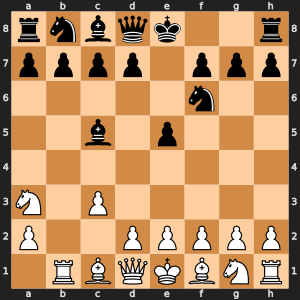

=== Player's Turn ===
Legal Moves:
h8g8 h8f8 e8f8 e8e7 d8e7
b8c6 b8a6 f6g8 f6h5 f6d5
f6g4 f6e4 c5f8 c5e7 c5d6
c5b6 c5d4 c5b4 c5e3 c5a3
c5f2 e8g8 h7h6 g7g6 d7d6
c7c6 b7b6 a7a6 e5e4 h7h5
g7g5 d7d5 b7b5 a7a5



KeyboardInterrupt: ignored

In [ ]:
# Agent vs Human

import chess
import chess.svg
from IPython.display import SVG, clear_output

def human_move(board):
    """
    This function lets the human input a move in UCI format (e.g., "g8f6").
    The move is checked for legality, and if it's illegal, the human is asked to input again.
    """
    legal_uci_moves = [board.uci(move) for move in board.legal_moves]
    print(f"Legal Moves:")
    for i in range(0, len(legal_uci_moves), 5):
        print(" ".join(legal_uci_moves[i:i+5]))
    print()
    while True:
        move_uci = input("Enter your move in UCI format (e.g., g8f6): ")
        if move_uci in legal_uci_moves:
            move_san = board.san(chess.Move.from_uci(move_uci))  # Convert UCI to SAN
            return move_san
        else:
            print("Illegal move! Try again.")

white = 1
moves = 0
pgn = []
game = chess.pgn.Game()
sm = 0
cnt = 0

while (not board.is_game_over()):
    clear_output(wait=True)  # Clear the previous board display
    display(SVG(chess.svg.board(board=board, size=300)))

    if white:  # if it's white's turn, let the agent play
        print("=== Agent's Turn ===")
        start = time.time()
        root = node()
        root.state = board
        result = mcts_pred(root, board.is_game_over(), white)
        sm += (time.time() - start)
        board.push_san(result)
        print(f"Agent's move: {result}")
    else:  # if it's black's turn, let the human play
        print("=== Player's Turn ===")
        result = human_move(board)
        board.push_san(result)
        print(f"Your move: {result}")

    pgn.append(result)
    white ^= 1
    cnt += 1
    moves += 1

print(board)
print(" ".join(pgn))
print()
print(board.result())
game.headers["Result"] = board.result()
print(game)
engine.quit()

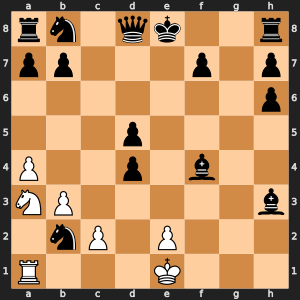

r n . . k . . r
p p . . . p . p
. . . . . . . p
. . . p . . . .
P . . p . b . q
N P . . . . . b
. n P . P . . .
R . . . K . . .
a3 e5 d4 exd4 b3 d5 f4 Be7 Qd3 c5 Qd2 Nf6 h4 Ne4 Bb2 Bxh4+ g3 Bxg3+ Kd1 Nxd2 Rh4 Nxf1 Rh6 Ne3+ Kd2 gxh6 Nh3 Bxh3 Bxd4 cxd4 a4 Bxf4 Na3 Nc4+ Kd1 Nb2+ Ke1 Qh4#

0-1
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "0-1"]

0-1


In [ ]:
# Agent vs Stockfish

import chess
import chess.svg
from IPython.display import SVG, clear_output

def stockfish_move(board, time_limit=0.1):
    """
    Get Stockfish's move given a board state.
    """
    result = engine.play(board, chess.engine.Limit(time=time_limit))
    return board.san(result.move)

white = 1
moves = 0
pgn = []
game = chess.pgn.Game()
sm = 0
cnt = 0

while (not board.is_game_over()):
    clear_output(wait=True)  # Clear the previous board display
    display(SVG(chess.svg.board(board=board, size=300)))

    if white:  # if it's white's turn, let the MCTS agent play
        print(f"=== Agent's Turn ({cnt}) ===")
        start = time.time()
        root = node()
        root.state = board
        result = mcts_pred(root, board.is_game_over(), white)
        sm += (time.time() - start)
        board.push_san(result)
    else:  # if it's black's turn, let Stockfish play
        result = stockfish_move(board)
        board.push_san(result)

    pgn.append(result)
    white ^= 1
    cnt += 1
    moves += 1

print(board)
print(" ".join(pgn))
print()
print(board.result())
game.headers["Result"] = board.result()
print(game)
engine.quit()